# Analysis and Clean Up v2

**Goal**: 
1. **Analyze**: Assess extraction quality by verifying evidence against full 10-K text. 
2. **Clean Up**: Standardize missing values, anchor evidence to exact source sentences using fuzzy matching, and identify the section each sentence belongs to.
3. **External Validation**: Validate manually-cleaned source sentences against raw EDGAR text.

In [1]:
%pip install pandas numpy matplotlib python-Levenshtein datasets regex

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt
import os  
import re 
import Levenshtein
from datasets import load_dataset
from datetime import datetime 
import regex    

## Configuration

In [3]:
GT_FILE = "../../data/ground_truth/v4_255_(1993)_(2-14-2026).csv"
OUTPUT_DIR = "../../data/clean_ground_truth"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# For External Validation (Section 6)
CLEANED_CSV_PATH = "../../data/clean_ground_truth/cleaned_EDGAR_gt_02-16-2026.csv"

# Fields to analyze
FIELD_IDS = [
    "registrant_name",
    "headquarters_city",
    "headquarters_state",
    "incorporation_state",
    "incorporation_year",
    "employees_count_total",
    "employees_count_full_time",
    "irs_tax_id",
    "ceo_lastname",
    "holder_record_amount"
]

# Fields kept in the final cleaned output (IRS dropped)
CLEAN_FIELD_IDS = [
    "registrant_name",
    "headquarters_city",
    "headquarters_state",
    "incorporation_state",
    "incorporation_year",
    "employees_count_total",
    "employees_count_full_time",
    "ceo_lastname",
    "holder_record_amount"
]

SECTION_KEYS = [
    "section_1", "section_1A", "section_1B", "section_2", "section_3",
    "section_4", "section_5", "section_6", "section_7", "section_7A",
    "section_8", "section_9", "section_9A", "section_9B", "section_10",
    "section_11", "section_12", "section_13", "section_14", "section_15"
]

## 1. Load Data & Build Full Context

In [4]:
# Load Ground Truth CSV
df = pd.read_csv(GT_FILE)
print(f"Loaded {len(df)} rows from {GT_FILE}")

def build_full_context(row):
    """Concatenates available sections into one full text string.
    Uses direct concatenation (no extra newlines) to preserve original formatting."""
    parts = []
    for key in SECTION_KEYS:
        if key in row and pd.notna(row[key]):
            val = str(row[key])
            if val not in ["nan", "None", "", "NULL"]:
                parts.append(val)
    return "".join(parts)

# Check if we need to fetch from HF
missing_sections = [col for col in SECTION_KEYS if col not in df.columns]

if missing_sections:
    print(f"Missing section columns: {missing_sections}. Fetching from HuggingFace...")
    dataset = load_dataset("c3po-ai/edgar-corpus", "default", split="train", streaming=True)
    
    needed_files = set(df["filename"].values)
    file_data = {}
    
    print("Streaming dataset to find matching files...")
    count = 0
    for doc in dataset:
        if doc["filename"] in needed_files:
            file_data[doc["filename"]] = doc
            count += 1
            if count >= len(needed_files):
                break
    
    for section in SECTION_KEYS:
        df[section] = df["filename"].map(lambda x: file_data.get(x, {}).get(section, ""))

# Build Full Text Column
print("Building 'full_text' column...")
df["full_text"] = df.apply(build_full_context, axis=1)
print("Done.")

Loaded 255 rows from ../../data/ground_truth/v4_255_(1993)_(2-14-2026).csv
Building 'full_text' column...
Done.


## 2. Analysis: Evidence Verification

In [14]:
def get_fingerprint(text):
    """Removes non-alphanumeric chars for robust comparison."""
    if not isinstance(text, str):
        return ""
    return re.sub(r'[\W_]+', '', text).lower()


def is_evidence_verified(row, field_id):
    """
    Boolean check: is the extracted evidence actually present in the filing text?
    
    Returns True if:
      - Value is NOT_FOUND (valid negative)
      - Evidence is an exact substring of full_text
      - Evidence matches via fingerprint (ignoring punctuation/whitespace)
    Returns False otherwise (hallucination or parse error).
    """
    val = str(row.get(f"{field_id}_value", "")).strip()
    evd = str(row.get(f"{field_id}_evidence", "")).strip()
    full_text = str(row.get("full_text", ""))
    
    # Error States
    if any(x in val.upper() for x in ["JSON_PARSE_ERROR", "PARSE_ERROR", "NO_CONTENT"]):
        return False
    
    # Valid Negative: value indicates not found
    if val.upper() in ["NOT_FOUND", "NULL", "NONE", "NAN", ""]:
        return True

    # Cannot verify without text
    if not full_text:
        return False
    
    # 1. Exact Match
    if evd in full_text:
        return True
    
    # 2. Fingerprint Match (ignore punctuation/whitespace)
    fp_text = get_fingerprint(full_text)
    fp_evd = get_fingerprint(evd)
    
    if fp_evd and fp_evd in fp_text:
        return True
    
    return False


# Apply Verification
print("Calculating verification status...")
for fid in FIELD_IDS:
    col_name = f"{fid}_verified"
    df[col_name] = df.apply(lambda row, f=fid: is_evidence_verified(row, f), axis=1)
    verified_pct = df[col_name].mean() * 100
    print(f"  {fid}: {verified_pct:.1f}% verified")

Calculating verification status...
  registrant_name: 98.4% verified
  headquarters_city: 97.6% verified
  headquarters_state: 97.6% verified
  incorporation_state: 98.0% verified
  incorporation_year: 98.4% verified
  employees_count_total: 95.7% verified
  employees_count_full_time: 98.4% verified
  irs_tax_id: 98.4% verified
  ceo_lastname: 89.4% verified
  holder_record_amount: 97.3% verified


### 2b. New Metrics

In [13]:
print("="*60)
print("METRIC 1: Unique Source Sentences per Category")
print("="*60)
for fid in FIELD_IDS:
    src_col = f"{fid}_source_sentence"
    if src_col in df.columns:
        non_nan = df[src_col].dropna()
        non_nan = non_nan[~non_nan.astype(str).str.upper().isin(["NOT_FOUND", "NULL", "NONE", "NAN", ""])]
        unique_count = non_nan.nunique()
        total_count = len(non_nan)
        print(f"  {fid}: {unique_count} unique / {total_count} total")

print()
print("="*60)
print("METRIC 2: Value Found but Source Sentence Missing")
print("  (LLM extracted a value but couldn't anchor it)")
print("="*60)
for fid in FIELD_IDS:
    val_col = f"{fid}_value"
    src_col = f"{fid}_source_sentence"
    if val_col in df.columns and src_col in df.columns:
        # Value is present (not a "not found" variant)
        has_value = ~df[val_col].astype(str).str.upper().isin(
            ["NOT_FOUND", "NULL", "NAN", "", "NONE", "NO_CONTENT", "JSON_PARSE_ERROR"]
        )
        # Source sentence is missing
        missing_src = df[src_col].isna() | df[src_col].astype(str).str.upper().isin(
            ["NOT_FOUND", "NULL", "NONE", "NAN", ""]
        )
        count = (has_value & missing_src).sum()
        print(f"  {fid}: {count} rows")

METRIC 1: Unique Source Sentences per Category
  registrant_name: 248 unique / 249 total
  headquarters_city: 166 unique / 166 total
  headquarters_state: 161 unique / 161 total
  incorporation_state: 188 unique / 190 total
  incorporation_year: 185 unique / 187 total
  employees_count_total: 171 unique / 177 total
  employees_count_full_time: 58 unique / 61 total
  irs_tax_id: 1 unique / 1 total
  ceo_lastname: 208 unique / 211 total
  holder_record_amount: 168 unique / 171 total

METRIC 2: Value Found but Source Sentence Missing
  (LLM extracted a value but couldn't anchor it)
  registrant_name: 4 rows
  headquarters_city: 4 rows
  headquarters_state: 4 rows
  incorporation_state: 4 rows
  incorporation_year: 4 rows
  employees_count_total: 4 rows
  employees_count_full_time: 4 rows
  irs_tax_id: 4 rows
  ceo_lastname: 4 rows
  holder_record_amount: 4 rows


## 3. Visualization

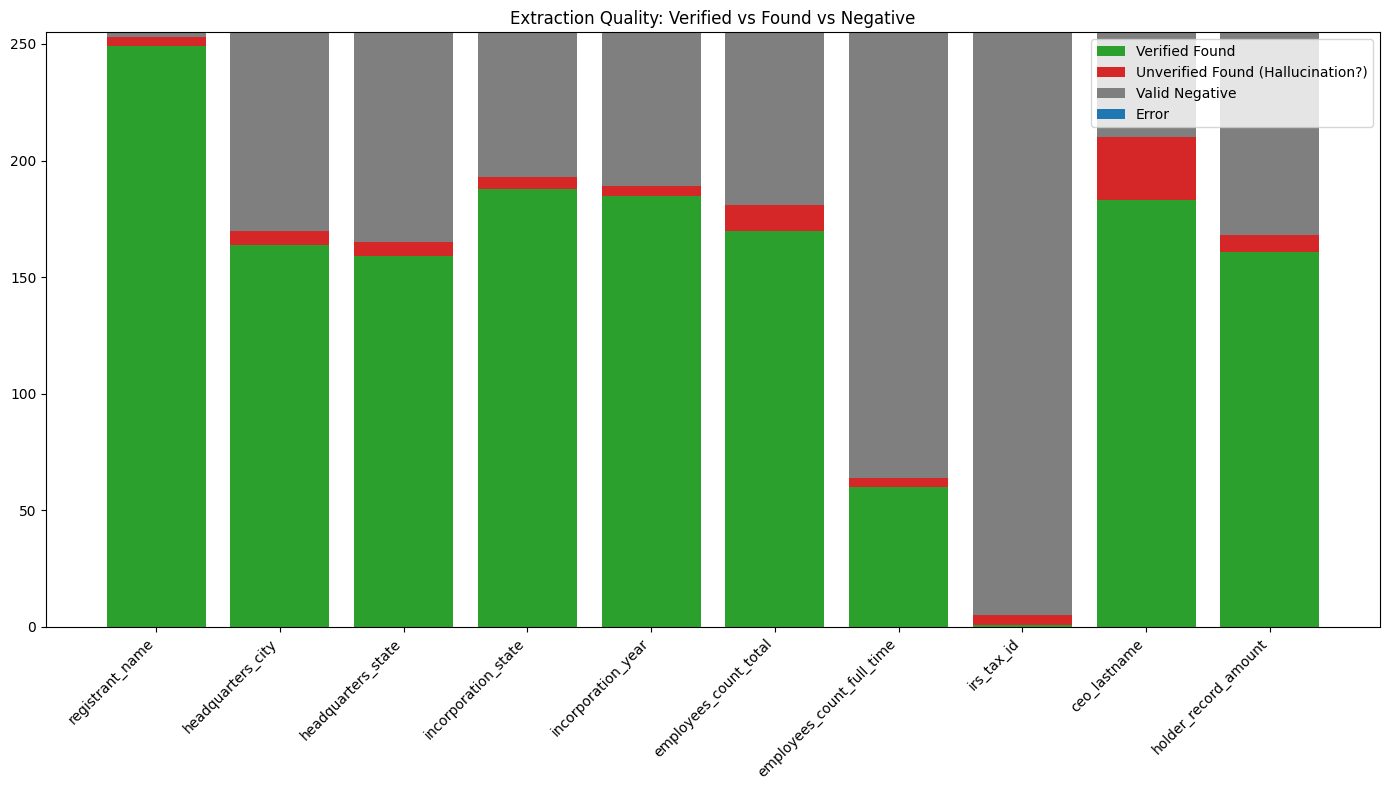

,Field,Verified Found,Unverified Found (Hallucination?),Valid Negative,Error
0,registrant_name,249,4,2,0
1,headquarters_city,164,6,85,0
2,headquarters_state,159,6,90,0
3,incorporation_state,188,5,62,0
4,incorporation_year,185,4,66,0
5,employees_count_total,170,11,74,0
6,employees_count_full_time,60,4,191,0
7,irs_tax_id,1,4,250,0
8,ceo_lastname,183,27,45,0
9,holder_record_amount,161,7,87,0


In [7]:
def analyze_field_status(df, field_ids):
    """Categorize each field's extraction quality."""
    stats = []
    for fid in field_ids:
        val_col = f"{fid}_value"
        verified_col = f"{fid}_verified"
        
        is_found = ~df[val_col].astype(str).str.upper().isin(
            ["NOT_FOUND", "NULL", "NAN", "", "NONE", "NO_CONTENT", "JSON_PARSE_ERROR"]
        )
        is_verified = df[verified_col]
        
        stats.append({
            "Field": fid,
            "Verified Found": (is_found & is_verified).sum(),
            "Unverified Found (Hallucination?)": (is_found & ~is_verified).sum(),
            "Valid Negative": (~is_found & is_verified).sum(),
            "Error": (~is_found & ~is_verified).sum()
        })
    
    return pd.DataFrame(stats)

stat_df = analyze_field_status(df, FIELD_IDS)

# Plot Stacked Bar Chart
fig, ax = plt.subplots(figsize=(14, 8))

fields = stat_df["Field"]
bottom = np.zeros(len(fields))

colors = {
    "Verified Found": "#2ca02c", 
    "Unverified Found (Hallucination?)": "#d62728", 
    "Valid Negative": "#7f7f7f", 
    "Error": "#1f77b4"
}

for col in ["Verified Found", "Unverified Found (Hallucination?)", "Valid Negative", "Error"]:
    ax.bar(fields, stat_df[col], bottom=bottom, label=col, color=colors[col])
    bottom += stat_df[col]

ax.set_title("Extraction Quality: Verified vs Found vs Negative")
ax.legend()
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

stat_df

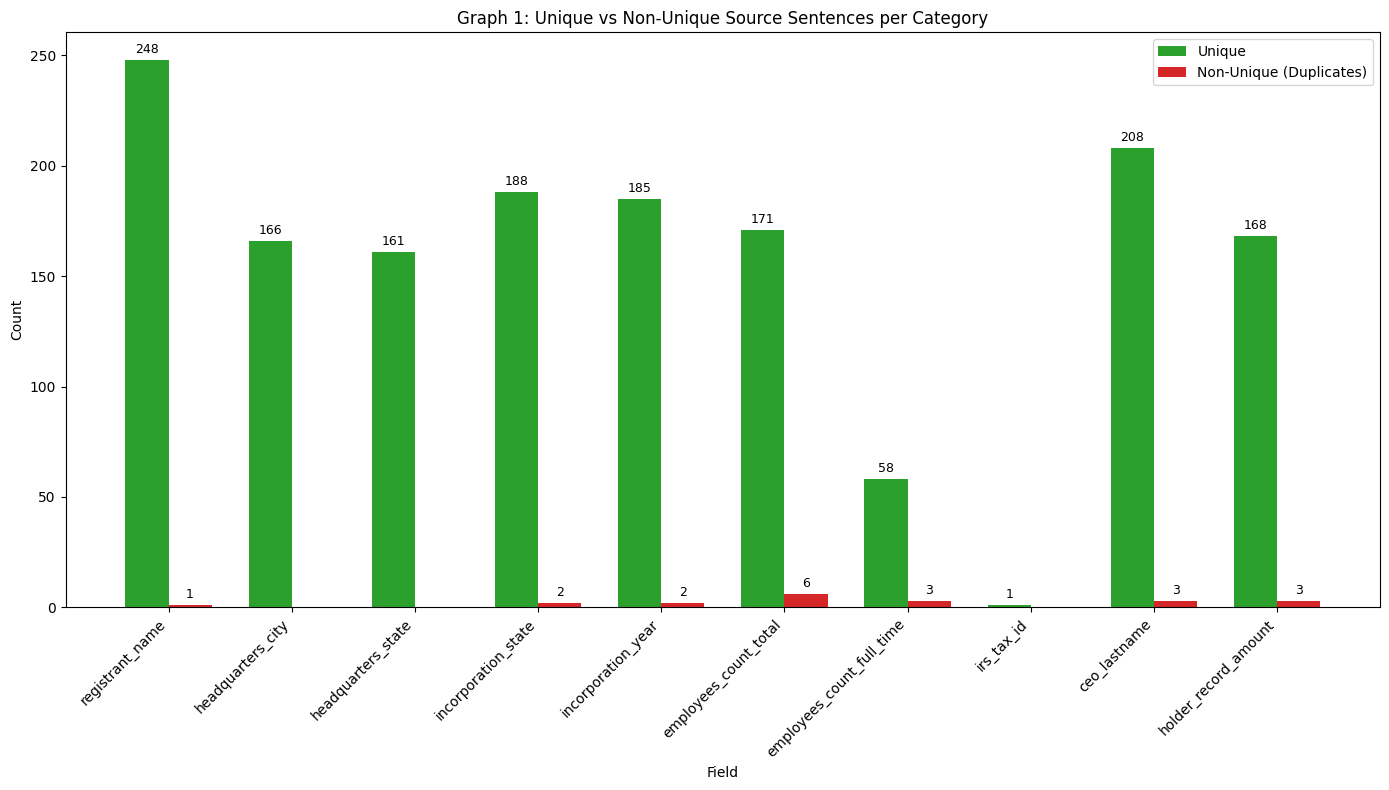

In [15]:
# --- Graph 1: Unique vs Non-Unique Source Sentences per Category ---

unique_data = []
for fid in FIELD_IDS:
    src_col = f"{fid}_source_sentence"
    if src_col in df.columns:
        non_nan = df[src_col].dropna()
        non_nan = non_nan[~non_nan.astype(str).str.upper().isin(["NOT_FOUND", "NULL", "NONE", "NAN", ""])]
        unique_count = non_nan.nunique()
        total_count = len(non_nan)
        unique_data.append({
            "Field": fid,
            "Unique": unique_count,
            "Non-Unique (Duplicates)": total_count - unique_count
        })

udf = pd.DataFrame(unique_data)

fig, ax = plt.subplots(figsize=(14, 8))
x = np.arange(len(udf))
width = 0.35

bars1 = ax.bar(x - width/2, udf["Unique"], width, label="Unique", color="#2ca02c")
bars2 = ax.bar(x + width/2, udf["Non-Unique (Duplicates)"], width, label="Non-Unique (Duplicates)", color="#d62728")

# Value labels
for bar in bars1:
    h = bar.get_height()
    if h > 0:
        ax.annotate(f'{int(h)}', xy=(bar.get_x() + bar.get_width()/2, h),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)
for bar in bars2:
    h = bar.get_height()
    if h > 0:
        ax.annotate(f'{int(h)}', xy=(bar.get_x() + bar.get_width()/2, h),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

ax.set_xlabel("Field")
ax.set_ylabel("Count")
ax.set_title("Graph 1: Unique vs Non-Unique Source Sentences per Category")
ax.set_xticks(x)
ax.set_xticklabels(udf["Field"], rotation=45, ha="right")
ax.legend()
plt.tight_layout()
plt.show()

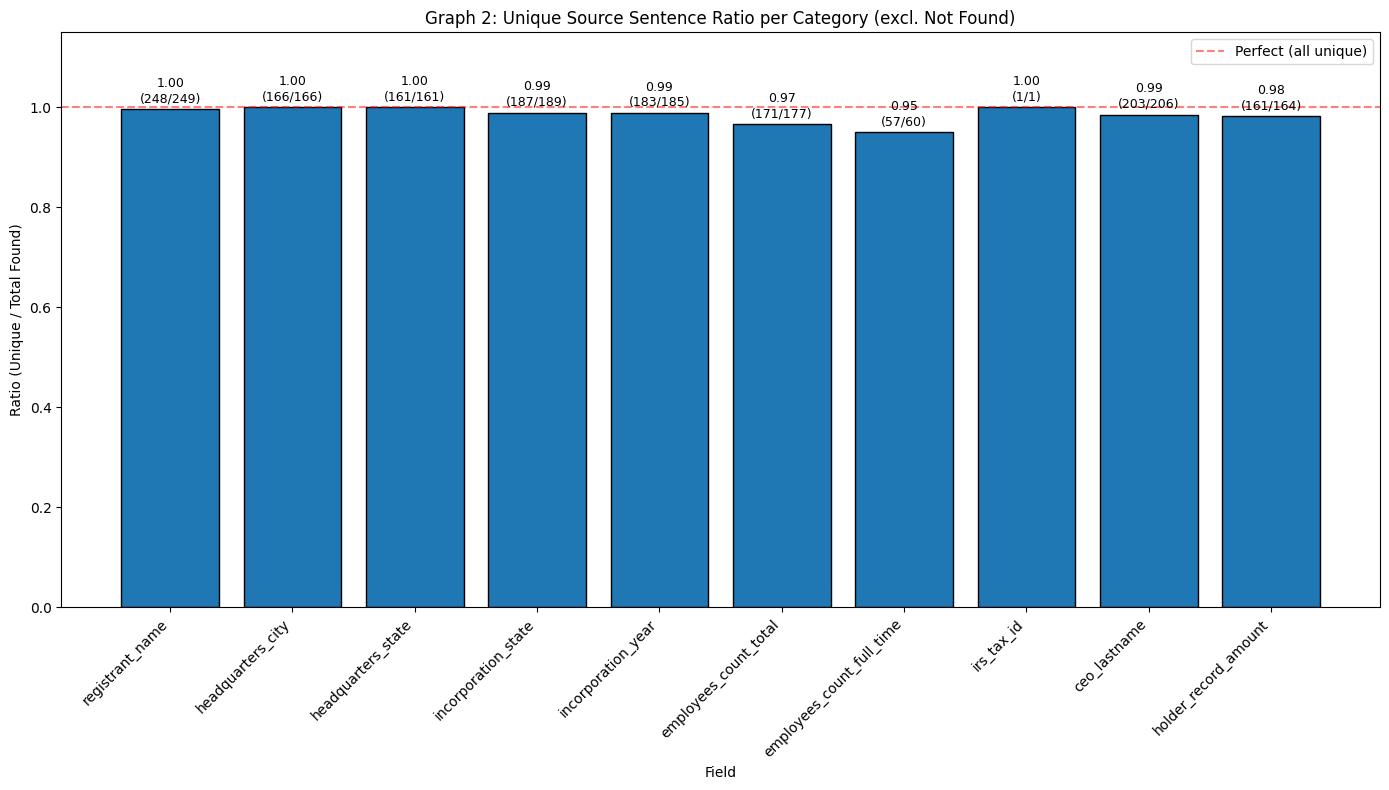

In [9]:
# --- Graph 2: Unique / Found Ratio per Category (excl. Not Found) ---

ratio_data = []
for fid in FIELD_IDS:
    val_col = f"{fid}_value"
    src_col = f"{fid}_source_sentence"
    if src_col in df.columns:
        # Only rows where a value was found
        has_value = ~df[val_col].astype(str).str.upper().isin(
            ["NOT_FOUND", "NULL", "NAN", "", "NONE", "NO_CONTENT", "JSON_PARSE_ERROR"]
        )
        found_src = df.loc[has_value, src_col].dropna()
        found_src = found_src[~found_src.astype(str).str.upper().isin(["NOT_FOUND", "NULL", "NONE", "NAN", ""])]
        
        unique_count = found_src.nunique()
        total_found = len(found_src)
        ratio = unique_count / total_found if total_found > 0 else 0
        ratio_data.append({"Field": fid, "Unique/Found Ratio": ratio, "Unique": unique_count, "Found": total_found})

rdf = pd.DataFrame(ratio_data)

fig, ax = plt.subplots(figsize=(14, 8))
bars = ax.bar(rdf["Field"], rdf["Unique/Found Ratio"], color="#1f77b4", edgecolor="black")

# Value labels
for bar, row_data in zip(bars, ratio_data):
    h = bar.get_height()
    ax.annotate(f'{h:.2f}\n({row_data["Unique"]}/{row_data["Found"]})',
                xy=(bar.get_x() + bar.get_width()/2, h),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

ax.set_xlabel("Field")
ax.set_ylabel("Ratio (Unique / Total Found)")
ax.set_title("Graph 2: Unique Source Sentence Ratio per Category (excl. Not Found)")
ax.set_ylim(0, 1.15)
ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Perfect (all unique)')
ax.legend()
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## 4. Clean Up & Source Anchoring

In [10]:
# --- Abbreviation-aware sentence splitter ---

# Common abbreviations that should NOT trigger a sentence split
ABBREVIATIONS = {
    "Inc", "Corp", "Co", "Ltd", "Mr", "Mrs", "Ms", "Dr", "Jr", "Sr",
    "No", "Nos", "vs", "etc", "approx", "Dept", "Div", "Est", "Vol",
    "Jan", "Feb", "Mar", "Apr", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec",
    "St", "Ave", "Blvd", "Rd", "Ct",
    "Cal", "Calif", "Colo", "Conn", "Del", "Fla", "Ill", "Ind", "Kan",
    "Ky", "Md", "Mass", "Mich", "Minn", "Miss", "Mo", "Mont", "Neb",
    "Nev", "Okla", "Ore", "Penn", "Tenn", "Tex", "Wash", "Wis",
}

# Build negative lookbehind pattern from abbreviations
_abbrev_pattern = "|".join(re.escape(a) for a in sorted(ABBREVIATIONS, key=len, reverse=True))

# Also protect patterns like "U.S." or "S.E.C." (letter-dot sequences)
# Pattern: split on period+whitespace UNLESS preceded by a known abbreviation
#          or a single uppercase letter (catches U.S., A.B.C., etc.)
SENTENCE_SPLIT_RE = regex.compile(
    r'(?<!\b(?:' + _abbrev_pattern + r'))'
    r'(?<!\b[A-Z])'
    r'[.!?]\s+',
    regex.MULTILINE
)


def smart_split_sentences(text):
    """Split text into sentences, protecting abbreviations and table-like lines."""
    if not text or not isinstance(text, str):
        return []
    
    # Use re.split but keep the delimiters to reconstruct properly
    # We'll use findall approach instead: find spans between split points
    parts = SENTENCE_SPLIT_RE.split(text)
    
    # Filter out empty/whitespace-only parts
    sentences = [p.strip() for p in parts if p.strip()]
    return sentences


def find_section_for_sentence(row, sentence):
    """Find which section_* column contains the given sentence."""
    if not sentence or not isinstance(sentence, str) or pd.isna(sentence):
        return np.nan
    
    for key in SECTION_KEYS:
        if key in row and pd.notna(row[key]):
            section_text = str(row[key])
            if sentence in section_text:
                return key
    
    # Fallback: fingerprint match
    fp_sent = get_fingerprint(sentence)
    if fp_sent:
        for key in SECTION_KEYS:
            if key in row and pd.notna(row[key]):
                fp_section = get_fingerprint(str(row[key]))
                if fp_sent in fp_section:
                    return key
    
    return np.nan


def find_best_source_sentence(full_text, evidence_snippet):
    """Find the best matching sentence in full_text for a given evidence snippet."""
    if not isinstance(full_text, str) or not isinstance(evidence_snippet, str):
        return np.nan
    if evidence_snippet.strip() in ["", "nan", "None", "NOT_FOUND", "NULL"]:
        return np.nan

    # Normalize newlines in both texts for consistent matching
    full_text_norm = full_text.replace("\\n", "\n")
    evidence_norm = evidence_snippet.replace("\\n", "\n")

    # 1. Exact substring match — return the evidence as-is
    if evidence_norm in full_text_norm:
        # For SHORT evidence (< 25 chars), we need to find the containing sentence
        if len(evidence_norm) < 25:
            sentences = smart_split_sentences(full_text_norm)
            containing = [s for s in sentences if evidence_norm in s]
            if len(containing) == 1:
                return containing[0].strip()
            elif len(containing) > 1:
                # Pick the shortest sentence that contains it (most specific)
                return min(containing, key=len).strip()
            else:
                return np.nan
        else:
            return evidence_norm.strip()

    # 2. Fuzzy Match — split into sentences and find best match
    sentences = smart_split_sentences(full_text_norm)
    if not sentences:
        return np.nan

    best_sent = None
    best_score = 0
    for sent in sentences:
        sent_stripped = sent.strip()
        if not sent_stripped:
            continue
        ratio = Levenshtein.ratio(evidence_norm, sent_stripped)
        if ratio > best_score:
            best_score = ratio
            best_sent = sent_stripped

    if best_score > 0.7:
        return best_sent

    return np.nan


In [11]:
# Copy DF for cleanup
clean_df = df.copy()

# CLEANUP LOOP
for fid in FIELD_IDS:
    print(f"\nCleaning & Anchoring: {fid}...")
    
    # 1. Standardize Nulls for Value
    val_col = f"{fid}_value"
    clean_df[val_col] = clean_df[val_col].replace(
        ["NOT_FOUND", "NULL", "", "NONE", "NO_CONTENT", "JSON_PARSE_ERROR"], np.nan
    )
    
    # 2. Determine found vs not-found
    mask_found = clean_df[val_col].notna()
    
    # Clear source/evidence for not-found rows
    clean_df.loc[~mask_found, f"{fid}_source_sentence"] = np.nan
    clean_df.loc[~mask_found, f"{fid}_evidence"] = np.nan
    
    # 3. Anchor source sentences for found rows
    skipped = 0
    anchored = 0
    failed = 0
    
    for idx in clean_df[mask_found].index:
        evd = str(clean_df.at[idx, f"{fid}_evidence"])
        ft = str(clean_df.at[idx, "full_text"])
        existing_src = clean_df.at[idx, f"{fid}_source_sentence"]
        if isinstance(existing_src, float) and np.isnan(existing_src):
            existing_src = None
        else:
            existing_src = str(existing_src)
        
        # Find or validate source sentence
        anchor_sent = find_best_source_sentence(ft, evd)
        clean_df.at[idx, f"{fid}_source_sentence"] = anchor_sent
        
        # Track stats
        if existing_src and anchor_sent == existing_src:
            skipped += 1
        elif pd.notna(anchor_sent):
            anchored += 1
        else:
            failed += 1
    
    # 4. Find section for each anchored source sentence
    section_col = f"{fid}_section"
    clean_df[section_col] = np.nan
    for idx in clean_df[mask_found].index:
        src = clean_df.at[idx, f"{fid}_source_sentence"]
        if pd.notna(src):
            clean_df.at[idx, section_col] = find_section_for_sentence(clean_df.loc[idx], str(src))
    
    print(f"  Skipped (already anchored): {skipped}")
    print(f"  Newly anchored: {anchored}")
    print(f"  Failed to anchor: {failed}")
    section_found = clean_df[section_col].notna().sum()
    print(f"  Section identified: {section_found}/{mask_found.sum()}")


Cleaning & Anchoring: registrant_name...
  Skipped (already anchored): 56
  Newly anchored: 186
  Failed to anchor: 11
  Section identified: 241/253

Cleaning & Anchoring: headquarters_city...


C:\Users\dersu\AppData\Local\Temp\ipykernel_43436\2038456983.py:53: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'section_1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  clean_df.at[idx, section_col] = find_section_for_sentence(clean_df.loc[idx], str(src))
C:\Users\dersu\AppData\Local\Temp\ipykernel_43436\2038456983.py:53: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'section_2' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  clean_df.at[idx, section_col] = find_section_for_sentence(clean_df.loc[idx], str(src))


  Skipped (already anchored): 23
  Newly anchored: 140
  Failed to anchor: 7
  Section identified: 162/170

Cleaning & Anchoring: headquarters_state...


C:\Users\dersu\AppData\Local\Temp\ipykernel_43436\2038456983.py:53: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'section_2' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  clean_df.at[idx, section_col] = find_section_for_sentence(clean_df.loc[idx], str(src))


  Skipped (already anchored): 21
  Newly anchored: 137
  Failed to anchor: 7
  Section identified: 156/165

Cleaning & Anchoring: incorporation_state...


C:\Users\dersu\AppData\Local\Temp\ipykernel_43436\2038456983.py:53: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'section_1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  clean_df.at[idx, section_col] = find_section_for_sentence(clean_df.loc[idx], str(src))


  Skipped (already anchored): 22
  Newly anchored: 164
  Failed to anchor: 7
  Section identified: 185/193

Cleaning & Anchoring: incorporation_year...


C:\Users\dersu\AppData\Local\Temp\ipykernel_43436\2038456983.py:53: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'section_1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  clean_df.at[idx, section_col] = find_section_for_sentence(clean_df.loc[idx], str(src))


  Skipped (already anchored): 24
  Newly anchored: 160
  Failed to anchor: 5
  Section identified: 184/189

Cleaning & Anchoring: employees_count_total...


C:\Users\dersu\AppData\Local\Temp\ipykernel_43436\2038456983.py:53: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'section_1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  clean_df.at[idx, section_col] = find_section_for_sentence(clean_df.loc[idx], str(src))
C:\Users\dersu\AppData\Local\Temp\ipykernel_43436\2038456983.py:53: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'section_1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  clean_df.at[idx, section_col] = find_section_for_sentence(clean_df.loc[idx], str(src))
C:\Users\dersu\AppData\Local\Temp\ipykernel_43436\2038456983.py:53: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'section_2' has dtype incompatib

  Skipped (already anchored): 33
  Newly anchored: 136
  Failed to anchor: 12
  Section identified: 169/181

Cleaning & Anchoring: employees_count_full_time...
  Skipped (already anchored): 11
  Newly anchored: 48
  Failed to anchor: 5
  Section identified: 59/64

Cleaning & Anchoring: irs_tax_id...
  Skipped (already anchored): 0
  Newly anchored: 1
  Failed to anchor: 4
  Section identified: 1/5

Cleaning & Anchoring: ceo_lastname...


C:\Users\dersu\AppData\Local\Temp\ipykernel_43436\2038456983.py:53: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'section_14' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  clean_df.at[idx, section_col] = find_section_for_sentence(clean_df.loc[idx], str(src))
C:\Users\dersu\AppData\Local\Temp\ipykernel_43436\2038456983.py:53: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'section_5' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  clean_df.at[idx, section_col] = find_section_for_sentence(clean_df.loc[idx], str(src))


  Skipped (already anchored): 37
  Newly anchored: 135
  Failed to anchor: 38
  Section identified: 172/210

Cleaning & Anchoring: holder_record_amount...
  Skipped (already anchored): 37
  Newly anchored: 123
  Failed to anchor: 8
  Section identified: 159/168


### Analysis After Clean Up

In [16]:
# Apply Verification
print("Calculating verification status...")
for fid in FIELD_IDS:
    col_name = f"{fid}_verified"
    clean_df[col_name] = clean_df.apply(lambda row, f=fid: is_evidence_verified(row, f), axis=1)
    verified_pct = clean_df[col_name].mean() * 100
    print(f"  {fid}: {verified_pct:.1f}% verified")

Calculating verification status...
  registrant_name: 98.4% verified
  headquarters_city: 97.6% verified
  headquarters_state: 97.6% verified
  incorporation_state: 98.0% verified
  incorporation_year: 98.4% verified
  employees_count_total: 95.7% verified
  employees_count_full_time: 98.4% verified
  irs_tax_id: 98.4% verified
  ceo_lastname: 89.4% verified
  holder_record_amount: 97.3% verified


In [17]:
print("="*60)
print("METRIC 1: Unique Source Sentences per Category")
print("="*60)
for fid in FIELD_IDS:
    src_col = f"{fid}_source_sentence"
    if src_col in clean_df.columns:
        non_nan = clean_df[src_col].dropna()
        non_nan = non_nan[~non_nan.astype(str).str.upper().isin(["NOT_FOUND", "NULL", "NONE", "NAN", ""])]
        unique_count = non_nan.nunique()
        total_count = len(non_nan)
        print(f"  {fid}: {unique_count} unique / {total_count} total")

print()
print("="*60)
print("METRIC 2: Value Found but Source Sentence Missing")
print("  (LLM extracted a value but couldn't anchor it)")
print("="*60)
for fid in FIELD_IDS:
    val_col = f"{fid}_value"
    src_col = f"{fid}_source_sentence"
    if val_col in clean_df.columns and src_col in clean_df.columns:
        # Value is present (not a "not found" variant)
        has_value = ~clean_df[val_col].astype(str).str.upper().isin(
            ["NOT_FOUND", "NULL", "NAN", "", "NONE", "NO_CONTENT", "JSON_PARSE_ERROR"]
        )
        # Source sentence is missing
        missing_src = clean_df[src_col].isna() | clean_df[src_col].astype(str).str.upper().isin(
            ["NOT_FOUND", "NULL", "NONE", "NAN", ""]
        )
        count = (has_value & missing_src).sum()
        print(f"  {fid}: {count} rows")

METRIC 1: Unique Source Sentences per Category
  registrant_name: 242 unique / 242 total
  headquarters_city: 163 unique / 163 total
  headquarters_state: 158 unique / 158 total
  incorporation_state: 181 unique / 186 total
  incorporation_year: 182 unique / 184 total
  employees_count_total: 167 unique / 169 total
  employees_count_full_time: 56 unique / 59 total
  irs_tax_id: 1 unique / 1 total
  ceo_lastname: 165 unique / 172 total
  holder_record_amount: 158 unique / 160 total

METRIC 2: Value Found but Source Sentence Missing
  (LLM extracted a value but couldn't anchor it)
  registrant_name: 11 rows
  headquarters_city: 7 rows
  headquarters_state: 7 rows
  incorporation_state: 7 rows
  incorporation_year: 5 rows
  employees_count_total: 12 rows
  employees_count_full_time: 5 rows
  irs_tax_id: 4 rows
  ceo_lastname: 38 rows
  holder_record_amount: 8 rows


## 5. Save Output

In [30]:
timestamp = datetime.now().strftime("%m-%d-%Y_%H-%M-%S")
out_path = os.path.join(OUTPUT_DIR, f"cleaned_EDGAR_gt_{timestamp}.csv")

# Columns to drop: full_text, all IRS columns, evidence/verified/found metadata
cols_to_drop = ['full_text']

# Drop ALL IRS columns
for suffix in ['_value', '_evidence', '_source_sentence', '_evidence_verified', '_found', '_verified', '_section']:
    cols_to_drop.append(f'irs_tax_id{suffix}')

# For kept fields, drop raw evidence, flags, and verification columns
for fid in CLEAN_FIELD_IDS:
    for suffix in ['_evidence', '_evidence_verified', '_found', '_verified']:
        cols_to_drop.append(f'{fid}{suffix}')

# Only drop columns that exist
cols_to_drop = [c for c in cols_to_drop if c in clean_df.columns]

final_df = clean_df.drop(columns=cols_to_drop)

print(f"Kept columns: {list(final_df.columns)}")
final_df.to_csv(out_path, index=False)
print(f"\nSaved cleaned dataset to: {out_path}")
print(f"Shape: {final_df.shape}")

Kept columns: ['filename', 'cik', 'year', 'section_1', 'section_1A', 'section_1B', 'section_2', 'section_3', 'section_4', 'section_5', 'section_6', 'section_7', 'section_7A', 'section_8', 'section_9', 'section_9A', 'section_9B', 'section_10', 'section_11', 'section_12', 'section_13', 'section_14', 'section_15', 'registrant_name_value', 'registrant_name_source_sentence', 'headquarters_city_value', 'headquarters_city_source_sentence', 'headquarters_state_value', 'headquarters_state_source_sentence', 'incorporation_state_value', 'incorporation_state_source_sentence', 'incorporation_year_value', 'incorporation_year_source_sentence', 'employees_count_total_value', 'employees_count_total_source_sentence', 'employees_count_full_time_value', 'employees_count_full_time_source_sentence', 'ceo_lastname_value', 'ceo_lastname_source_sentence', 'holder_record_amount_value', 'holder_record_amount_source_sentence', 'registrant_name_section', 'headquarters_city_section', 'headquarters_state_section', '

## 6. External Validation

**Goal**: Validate a *manually cleaned* ground truth CSV against the raw EDGAR filing text.  
- Check if each `source_sentence` exists verbatim in the filing.  
- If not, use robust regex matching (ignoring whitespace, newlines, casing).  
- On match: update `source_sentence` to exact raw text and populate `section` column.

In [31]:
# Load the cleaned CSV for validation
val_df = pd.read_csv(CLEANED_CSV_PATH)
print(f"Loaded {len(val_df)} rows from {CLEANED_CSV_PATH}")

# Build full text for validation (same logic as Section 1)
print("Building full_text for validation...")
val_df["full_text"] = val_df.apply(build_full_context, axis=1)
print("Done.")

# Fields in the cleaned CSV (no IRS)
VAL_FIELD_IDS = CLEAN_FIELD_IDS

Loaded 255 rows from ../../data/clean_ground_truth/cleaned_EDGAR_gt_02-16-2026.csv
Building full_text for validation...
Done.


In [32]:
def build_robust_regex(sentence):
    """Build a regex pattern from a sentence that ignores extra whitespace,
    newlines, and is case-insensitive."""
    if not isinstance(sentence, str):
        return None
    # Escape regex special chars, then replace whitespace runs with flexible whitespace matcher
    escaped = re.escape(sentence)
    pattern = re.sub(r'\\\s+', r'\\s+', escaped)  # Allow flexible whitespace
    pattern = re.sub(r'\\\\n', r'\\s+', pattern)   # Handle literal \n in source
    try:
        return re.compile(pattern, re.IGNORECASE | re.DOTALL)
    except re.error:
        return None

def find_section_for_sentence_val(row, sentence):
    """Find which section contains the sentence."""
    if not isinstance(sentence, str) or not sentence.strip():
        return np.nan
    for key in SECTION_KEYS:
        if key in row and pd.notna(row[key]):
            section_text = str(row[key]).replace("\\n", "\n")
            if sentence in section_text:
                return key
    return np.nan

print("Running external validation...")
print("=" * 60)

for fid in VAL_FIELD_IDS:
    src_col = f"{fid}_source_sentence"
    section_col = f"{fid}_section"

    if src_col not in val_df.columns:
        continue
    if section_col not in val_df.columns:
        val_df[section_col] = np.nan

    exact_count = 0
    regex_count = 0
    not_found_count = 0
    no_source_count = 0

    for idx in val_df.index:
        src = val_df.at[idx, src_col]
        if pd.isna(src) or str(src).strip() in ["", "nan", "None", "NULL", "NOT_FOUND"]:
            no_source_count += 1
            continue

        src_str = str(src).strip()
        # Normalize literal \n to actual newlines
        src_norm = src_str.replace("\\n", "\n")
        full_text = str(val_df.at[idx, "full_text"]).replace("\\n", "\n")

        # 1. Exact match (after normalization)
        if src_norm in full_text:
            exact_count += 1
            # Update source_sentence to the normalized version
            if src_str != src_norm:
                val_df.at[idx, src_col] = src_norm
            # Populate section if missing
            if pd.isna(val_df.at[idx, section_col]):
                section = find_section_for_sentence_val(val_df.loc[idx], src_norm)
                if pd.notna(section):
                    val_df.at[idx, section_col] = section
            continue

        # 2. Robust regex match
        pattern = build_robust_regex(src_str)
        if pattern:
            match = pattern.search(full_text)
            if match:
                regex_count += 1
                val_df.at[idx, src_col] = match.group(0)
                if pd.isna(val_df.at[idx, section_col]):
                    section = find_section_for_sentence_val(val_df.loc[idx], match.group(0))
                    if pd.notna(section):
                        val_df.at[idx, section_col] = section
                continue

        not_found_count += 1

    total = len(val_df)
    print(f"  {fid}:")
    print(f"    Exact match:   {exact_count}/{total}")
    print(f"    Regex match:   {regex_count}/{total} (source_sentence updated)")
    print(f"    Not found:     {not_found_count}/{total}")
    print(f"    No source:     {no_source_count}/{total}")


Running external validation...
  registrant_name:
    Exact match:   212/255
    Regex match:   0/255 (source_sentence updated)
    Not found:     37/255
    No source:     6/255
  headquarters_city:
    Exact match:   132/255
    Regex match:   0/255 (source_sentence updated)
    Not found:     21/255
    No source:     102/255


C:\Users\dersu\AppData\Local\Temp\ipykernel_28764\3978401702.py:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'section_1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  val_df.at[idx, section_col] = section
C:\Users\dersu\AppData\Local\Temp\ipykernel_28764\3978401702.py:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'section_2' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  val_df.at[idx, section_col] = section
C:\Users\dersu\AppData\Local\Temp\ipykernel_28764\3978401702.py:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'section_2' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  val_df.at[idx, section_col]

  headquarters_state:
    Exact match:   129/255
    Regex match:   0/255 (source_sentence updated)
    Not found:     19/255
    No source:     107/255
  incorporation_state:
    Exact match:   157/255
    Regex match:   0/255 (source_sentence updated)
    Not found:     29/255
    No source:     69/255
  incorporation_year:
    Exact match:   144/255
    Regex match:   0/255 (source_sentence updated)
    Not found:     28/255
    No source:     83/255
  employees_count_total:
    Exact match:   147/255
    Regex match:   0/255 (source_sentence updated)
    Not found:     24/255
    No source:     84/255
  employees_count_full_time:
    Exact match:   50/255
    Regex match:   0/255 (source_sentence updated)
    Not found:     11/255
    No source:     194/255


C:\Users\dersu\AppData\Local\Temp\ipykernel_28764\3978401702.py:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'section_1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  val_df.at[idx, section_col] = section
C:\Users\dersu\AppData\Local\Temp\ipykernel_28764\3978401702.py:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'section_1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  val_df.at[idx, section_col] = section
C:\Users\dersu\AppData\Local\Temp\ipykernel_28764\3978401702.py:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'section_1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  val_df.at[idx, section_col]

  ceo_lastname:
    Exact match:   106/255
    Regex match:   0/255 (source_sentence updated)
    Not found:     88/255
    No source:     61/255
  holder_record_amount:
    Exact match:   142/255
    Regex match:   0/255 (source_sentence updated)
    Not found:     19/255
    No source:     94/255


C:\Users\dersu\AppData\Local\Temp\ipykernel_28764\3978401702.py:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'section_5' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  val_df.at[idx, section_col] = section


In [34]:
# ====================================================================
# INVESTIGATION: Explore failed anchors & unmatched source sentences
# ====================================================================

# --- 1. CLEANING FAILURES: Rows where anchoring FAILED ---
print("=" * 80)
print("SECTION 4 FAILURES: Rows where source_sentence could NOT be anchored")
print("=" * 80)

for fid in CLEAN_FIELD_IDS:
    val_col = f"{fid}_value"
    src_col = f"{fid}_source_sentence"
    evd_col = f"{fid}_evidence"
    
    mask_has_value = clean_df[val_col].notna()
    mask_no_source = clean_df[src_col].isna()
    failed = clean_df[mask_has_value & mask_no_source]
    
    if len(failed) > 0:
        print(f"\n--- {fid}: {len(failed)} failed rows ---")
        for idx in failed.index[:3]:  # Show up to 3 examples
            print(f"  Row {idx} | filename: {clean_df.at[idx, 'filename']}")
            print(f"    Value:    {str(clean_df.at[idx, val_col])[:80]}")
            evd = str(clean_df.at[idx, evd_col]) if evd_col in clean_df.columns else "N/A"
            print(f"    Evidence: {evd[:120]}")
            ft = str(clean_df.at[idx, 'full_text'])
            print(f"    Evidence in full_text? {evd in ft}")
            print()

# --- 2. EXTERNAL VALIDATION FAILURES: "Not found" source sentences ---
print("\n" + "=" * 80)
print("SECTION 6 FAILURES: source_sentence present but NOT in filing text")
print("=" * 80)

for fid in VAL_FIELD_IDS:
    src_col = f"{fid}_source_sentence"
    if src_col not in val_df.columns:
        continue
    
    shown = 0
    for idx in val_df.index:
        if shown >= 3:
            break
        src = val_df.at[idx, src_col]
        if pd.isna(src) or str(src).strip() in ["", "nan", "None", "NULL", "NOT_FOUND"]:
            continue
        src = str(src).strip()
        ft = str(val_df.at[idx, "full_text"])
        if src not in ft:
            print(f"\n--- {fid} | Row {idx} | {val_df.at[idx, 'filename']} ---")
            print(f"  Source ({len(src)} chars): {src[:150]}...")
            # Try to find a close match
            best_ratio = 0
            best_chunk = ""
            for i in range(0, max(1, len(ft) - len(src)), 50):
                chunk = ft[i:i+len(src)+20]
                ratio = Levenshtein.ratio(src, chunk)
                if ratio > best_ratio:
                    best_ratio = ratio
                    best_chunk = chunk
            if best_ratio > 0.5:
                print(f"  Closest match ({best_ratio:.2f}): {best_chunk[:150]}...")
            shown += 1


# --- 3. INCORPORATION_YEAR deep dive (biggest failure) ---
print("\n" + "=" * 80)
print("DEEP DIVE: incorporation_year (89 failed anchors)")
print("=" * 80)

fid = "incorporation_year"
val_col = f"{fid}_value"
src_col = f"{fid}_source_sentence"
evd_col = f"{fid}_evidence"

mask_has_value = clean_df[val_col].notna()
mask_no_source = clean_df[src_col].isna()
failed_iy = clean_df[mask_has_value & mask_no_source]

# Characterize the evidence snippets
evd_lengths = failed_iy[evd_col].astype(str).str.len()
print(f"  Failed rows: {len(failed_iy)}")
print(f"  Evidence length stats:")
print(f"    Mean: {evd_lengths.mean():.0f} chars")
print(f"    Median: {evd_lengths.median():.0f} chars")
print(f"    Min: {evd_lengths.min()} chars")
print(f"    Max: {evd_lengths.max()} chars")

print(f"\n  Sample failed evidence snippets:")
for idx in failed_iy.index[:5]:
    evd = str(clean_df.at[idx, evd_col])
    in_text = evd in str(clean_df.at[idx, 'full_text'])
    print(f"    [{idx}] '{evd[:100]}' | in_text={in_text}")


SECTION 4 FAILURES: Rows where source_sentence could NOT be anchored

--- registrant_name: 11 failed rows ---
  Row 8 | filename: 53540_1993.txt
    Value:    JILCO INDUSTRIES, INC.
    Evidence: JILCO INDUSTRIES, INC.
    Evidence in full_text? True

  Row 18 | filename: 743443_1993.txt
    Value:    NO_TEXT
    Evidence: nan
    Evidence in full_text? False

  Row 93 | filename: 352363_1993.txt
    Value:    NO_TEXT
    Evidence: nan
    Evidence in full_text? False


--- headquarters_city: 7 failed rows ---
  Row 5 | filename: 60041_1993.txt
    Value:    Newington
    Evidence: The North American Region Headquarters in Newington, Connecticut
    Evidence in full_text? False

  Row 18 | filename: 743443_1993.txt
    Value:    NO_TEXT
    Evidence: nan
    Evidence in full_text? False

  Row 25 | filename: 711404_1993.txt
    Value:    Pleasanton
    Evidence: Corporate Headquarters Pleasanton, California
    Evidence in full_text? False


--- headquarters_state: 7 failed rows ---
  

In [ ]:
# Save the validated CSV
val_timestamp = datetime.now().strftime("%m-%d-%Y_%H-%M-%S")
val_out_path = os.path.join(OUTPUT_DIR, f"validated_EDGAR_gt_{val_timestamp}.csv")

# Drop full_text before saving
val_save_df = val_df.drop(columns=["full_text"], errors="ignore")
val_save_df.to_csv(val_out_path, index=False)
print(f"Saved validated dataset to: {val_out_path}")
print(f"Shape: {val_save_df.shape}")